<a href="https://colab.research.google.com/github/kumiori/mec647/blob/main/En_passant_Sarah.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import site
import sys


try : 
    from google.colab import files
except:
    pass
    
try:
    from fenics import *; from mshr import *
except ImportError as e:
    !apt-get install software-properties-common
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y fenics    
    site.addsitedir('/usr/lib/petsc/lib/python3/dist-packages')  # Always appends to end

    from fenics import *; from mshr import *
    from ufl import replace

!fenics-version

Reading package lists... Done
Building dependency tree       
Reading state information... Done
software-properties-common is already the newest version (0.96.24.32.14).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.
Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubu

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Geometry

L1=10;
L = 10/L1; H = 5/L1;
l0 = 1/L1; w = 2/L1;
L1=(L-w)/2;
L2=(L+w)/2;
H1=H-l0;
epsilon = 0.005; 


plate = Rectangle(Point(0,0), Point(L, H))

notchVertices1 = [Point(L2-epsilon, H), Point(L2 , H1), Point(L2 + epsilon , H)]
notch1 = Polygon(notchVertices1)
notchVertices2 = [Point(L1+epsilon, 0), Point(L1 , l0), Point(L1 - epsilon ,0)]
notch2 = Polygon(notchVertices2)

domain = plate - notch1 - notch2 

cellSize = .03
nel = H / cellSize
mesh   = generate_mesh(domain, nel)


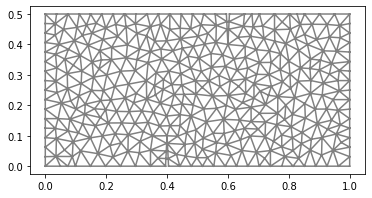

In [4]:
plot(mesh)

In [5]:
ndim = mesh.topology().dim()

cell_mrk = MeshFunction('bool', mesh, ndim)
cell_mrk.set_all(False)

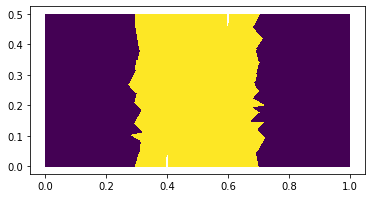

In [6]:
for cell in cells(mesh):
  if 0.3 < cell.midpoint()[0] < 0.7:
    cell_mrk[cell] = True

plot(cell_mrk)

for i in range(2): mesh = refine(mesh, cell_mrk)
# mesh = refine(mesh, cell_mrk)

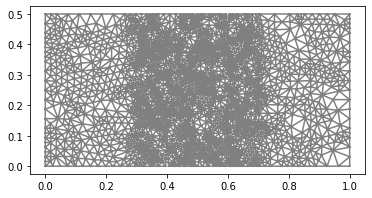

In [7]:
plot(mesh)

In [8]:
V_u = VectorFunctionSpace(mesh, 'CG', 1)
V_alpha = FunctionSpace(mesh, 'CG', 1)

u = Function(V_u)
du = TrialFunction(V_u)
v = TestFunction(V_u)

alpha = Function(V_alpha)
beta = TestFunction(V_alpha)
dalpha = TrialFunction(V_alpha)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [9]:
ut = Expression('t', t=0., degree=0)

bcs_u = [DirichletBC(V_u.sub(1), ut, 'near(x[0], {}, 1e-5)'.format(0)), 
         DirichletBC(V_u.sub(1), Constant(0.), 'near(x[0], {}, 1e-5)'.format(L))]



bca_0 = DirichletBC(V_alpha, Constant(0.), 'near(x[0], {}, 1e-5)'.format(0))
bca_1 = DirichletBC(V_alpha, Constant(0.), 'near(x[0], {}, 1e-5)'.format(L))

bc_alpha = [bca_0, bca_1]

In [11]:
# Constitutive

# Constitutive functions

E, nu = Constant(1.), Constant(.0)
Gc = Constant(1.)
ell = Constant(0.05)

ndim = mesh.topology().dim()

def w(alpha):
  return alpha

def a(alpha):
  return (1-alpha)**2

def eps(u):
  return sym(grad(u))

def sigma0(u):
  mu = E/(2.*(1.+nu))
  lmbda = E*nu/(1-nu**2.)
  return 2*mu*eps(u) + lmbda*tr(eps(u))*Identity(ndim)

def sigma(alpha, u):
  return a(alpha)*sigma0(u)

In [12]:
import sympy

s = sympy.Symbol('s')
cw = float(sympy.integrate(4*sympy.sqrt(w(s)), (s, 0, 1)))


tmp = 2*(sympy.diff(w(s),s)/sympy.diff(1/a(s),s)).subs({"s":0})

print("Gc = %2.3f"%((ell*cw)/tmp))

Gc = Constant((ell*cw)/tmp)

Gc = 0.133


In [13]:
# Energetics


elastic_energy = 0.5*inner(sigma(alpha, u), eps(u))*dx
dissipated_energy = Gc/cw * (w(alpha)/ell + ell* inner(grad(alpha), grad(alpha)))*dx

total_energy = elastic_energy + dissipated_energy 

E_u = derivative(total_energy, u, v)

from ufl import replace
E_du = replace(E_u, {u: du})

E_alpha = derivative(total_energy, alpha, beta)
E_alpha_alpha = derivative(E_alpha,alpha, dalpha)

In [14]:
# construction of linear and bilinear forms

# problem_u = LinearVariationalProblem()
problem_u = LinearVariationalProblem(lhs(E_du), rhs(E_du), u, bcs_u)
solver_u = LinearVariationalSolver(problem_u)
solver_u.parameters.update({"linear_solver" : "umfpack"})

# Alternatively, compute explicitly:

A = inner(sigma(alpha, du), eps(v))*dx
# f0, g0 exist in L^2(\Omega), L^2(\partial\Omega)
# LL = dot(f0, v)*dx + dot(g0, v)*ds
zero = project(Constant((0., 0.)), V_u)
LL = dot(zero, v)*dx

problem_u = LinearVariationalProblem(A, LL, u, bcs_u)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [16]:
# u = TrialFunction(V_u)
ut.t = .1
solver_u.solve()

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


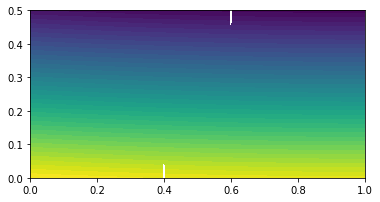

In [17]:
# dir(plot, mo)
plot(dot(u,u))

In [18]:
# Bounds

upperbound = project(Constant(1.), V_alpha)
lowerbound = project(Constant(0.), V_alpha)

# Boundary conditions
# set damage = 0 where we impose displacement boundary conditions

# bc_a1 = DirichletBC(V_alpha, Constant(0.), left)
# bc_a2 = DirichletBC(V_alpha, Constant(0.), right)

# bc_a = [bc_a1, bc_a2]

# Nonlinear problem and solver

problem_alpha = NonlinearVariationalProblem(E_alpha, alpha, bc_alpha, J=E_alpha_alpha)
problem_alpha.set_bounds(lowerbound, upperbound)

# solver able to solve with bounds: SNES

solver_alpha = NonlinearVariationalSolver(problem_alpha)
# info(solver_alpha.parameters, True)

snes_solver_parameters_bounds = {"nonlinear_solver": "snes", 
                                 "snes_solver": {"maximum_iterations": 300,
                                                 "absolute_tolerance": 1e-10,
                                                 "relative_tolerance": 1e-5,
                                                 "solution_tolerance": 1e-5,
                                                 "report": True,
                                                 "linear_solver" : "mumps"
                                                 }
                                }
# Solver method  |  Description                                                 
# ------------------------------------------------------------------------------
# bicgstab       |  Biconjugate gradient stabilized method                      
# cg             |  Conjugate gradient method                                   
# default        |  default linear solver                                       
# gmres          |  Generalized minimal residual method                         
# minres         |  Minimal residual method                                     
# mumps          |  MUMPS (MUltifrontal Massively Parallel Sparse direct Solver)
# petsc          |  PETSc built in LU solver                                    
# richardson     |  Richardson method                                           
# superlu        |  SuperLU                                                     
# tfqmr          |  Transpose-free quasi-minimal residual method                
# umfpack        |  UMFPACK (Unsymmetric MultiFrontal sparse LU factorization)  

solver_alpha.parameters.update(snes_solver_parameters_bounds)

solver_alpha.solve()



Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


(0, True)

In [21]:
# boundaries
gauche = CompiledSubDomain("near(x[0], {}, 1e-4)".format(0))
droite = CompiledSubDomain("near(x[0], {}, 1e-4)".format(L))

# right = CompiledSubDomain("near(x[0], {}, 1e-4)".format(Lx/2.))

boundaries = MeshFunction("size_t", mesh, 1)
boundaries.set_all(0)
gauche.mark(boundaries, 1) # mark gauche as 1
droite.mark(boundaries, 2) # mark droite as 2
#right.mark(boundaries, 3) # mark right as 3
ds = Measure("ds",subdomain_data=boundaries) # top: ds(1), bottom: ds(2), right


Moving new file over differing existing file:
src: /content/jitfailure-dolfin_subdomain_691d130ca9f9eaab11ee4c8b1adae548/error.log.418ffa1bad4841caa13516da774dc0a4
dst: /content/jitfailure-dolfin_subdomain_691d130ca9f9eaab11ee4c8b1adae548/error.log
backup: /content/jitfailure-dolfin_subdomain_691d130ca9f9eaab11ee4c8b1adae548/error.log.old
Backup file exists, overwriting.
------------------- Start compiler output ------------------------
/tmp/tmpzbmwty8r/dolfin_subdomain_691d130ca9f9eaab11ee4c8b1adae548.cpp:63:58: error: stray ‘#’ in program
          return near(x[0], { (f_71) . (v_0) } * dx(<Mesh #31>[everywhere], {}), 1e-4);
                                                          ^
/tmp/tmpzbmwty8r/dolfin_subdomain_691d130ca9f9eaab11ee4c8b1adae548.cpp: In member function ‘virtual bool dolfin::dolfin_subdomain_691d130ca9f9eaab11ee4c8b1adae548::inside(Eigen::Ref<const Eigen::Matrix<double, -1, 1> >, bool) const’:
/tmp/tmpzbmwty8r/dolfin_subdomain_691d130ca9f9eaab11ee4c8b1adae548.cpp:

RuntimeError: ignored